# Face Generation
In this project, we are demonstrating how to use generative adversarial networks to generate new images of faces.
### Get the Data
We will be using two datasets in this project:
- MNIST (handwritten digits)
- CelebA (facial images of celebrities)

Since the celebA dataset is complex we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow us to see how well our model trains sooner.

In [9]:
# Installing dependencies
!pip install Pillow
!pip install image
!pip install numpy
!pip install tqdm

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/99/c8/550f3416afe7b6726efc8a7f2249a38d6ae65c3514ef6c36bdc8485868b7/Pillow-5.3.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl


In [4]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 504kB/s ta 0:00:01


In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

ModuleNotFoundError: No module named 'tqdm'

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

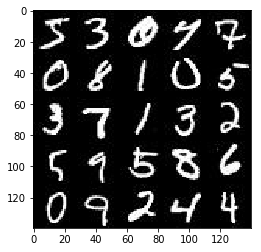

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

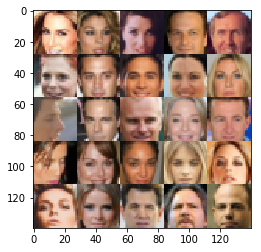

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/bernhardmayr/anaconda/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, 
                                (None, image_width, image_height, image_channels),
                                name='input_real')
    
    input_z = tf.placeholder(tf.float32, 
                             (None, z_dim), 
                             name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, 
                                   [], 
                                   name='lr')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [14]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    kinit = tf.random_normal_initializer(stddev=0.02)
    with tf.variable_scope('discriminator', reuse=reuse):
        '''
        images_shape = images.get_shape()
        n_units = int(images_shape[1] * images_shape[2] * images_shape[3])
        alpha = 0.01
        
        images = tf.reshape(images, [-1, n_units])

        # hidden layer
        hidden = tf.layers.dense(images, n_units, activation=None)
        # leaky relu
        hidden = tf.maximum(alpha*hidden, hidden)
        
        #logits and tanh output
        logits = tf.layers.dense(hidden, 1, activation=None)
        output = tf.sigmoid(logits)
        '''
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, kernel_initializer=kinit, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print (relu3.shape)
        # 2x2x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [15]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    print("generator->z.get_shape: ", z.get_shape())
    print("generator->out_channel_dim: ", out_channel_dim)
    print("generator->is_train: ", is_train)
    
    reuse = not is_train    
    alpha=0.02
    
    kinit = tf.random_normal_initializer(stddev=0.02)

    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, kernel_initializer=kinit, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        #print (x3.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        #print (logits.shape)
        # 28x28x3 now
        
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  5
generator->is_train:  True
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  5
generator->is_train:  False
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """    
    # TODO: Implement Function
    # Build the model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Smoothing 
    smooth = 0.1
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))
    
    print (d_model_real)
    print (d_logits_real)
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  4
generator->is_train:  True
Tensor("discriminator/Sigmoid:0", shape=(?, 1), dtype=float32)
Tensor("discriminator/dense/BiasAdd:0", shape=(?, 1), dtype=float32)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
   
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    print("model_opt->g_vars: ")
    for g_var in g_vars: print(g_var)
        
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    print("model_opt->d_vars: ")
    for d_var in d_vars: print(d_var)
    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

model_opt->g_vars: 
Tensor("generator/Variable/read:0", shape=(3, 3), dtype=float32)
model_opt->d_vars: 
Tensor("discriminator/Variable/read:0", shape=(3, 3), dtype=float32)
Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
from IPython.core.debugger import set_trace
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, l_rate = model_inputs(data_shape[1], data_shape[2], len(data_image_mode), z_dim)
          
    l_rate = learning_rate    
    #print("train->l_rate: ", l_rate)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples = []
    losses = []
    
    with tf.Session() as sess:
        #set_trace()
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 0
            for batch_images in get_batches(batch_size):
                i += 1
                # TODO: Train Model
                
                batch_images = batch_images*2
                
                # Sample random noise for G                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))                     
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                
                if i % 10 == 0:                    
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show output every 100 batches
                if i % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                              
            # At the end of each epoch, get the losses and print them out
           
            
            print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))    
            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))
            print("train->len(losses): ", len(losses))
        
            # Sample from generator as we're training for viewing afterwards
            sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
            gen_samples = sess.run(
                           generator(input_z, data_shape[3], is_train=False),
                           feed_dict={input_z: sample_z})
            samples.append(gen_samples)    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  True
model_opt->g_vars: 
Tensor("generator/dense/kernel/read:0", shape=(100, 2048), dtype=float32)
Tensor("generator/dense/bias/read:0", shape=(2048,), dtype=float32)
Tensor("generator/batch_normalization/beta/read:0", shape=(512,), dtype=float32)
Tensor("generator/batch_normalization/gamma/read:0", shape=(512,), dtype=float32)
Tensor("generator/conv2d_transpose/kernel/read:0", shape=(5, 5, 256, 512), dtype=float32)
Tensor("generator/conv2d_transpose/bias/read:0", shape=(256,), dtype=float32)
Tensor("generator/batch_normalization_1/beta/read:0", shape=(256,), dtype=float32)
Tensor("generator/batch_normalization_1/gamma/read:0", shape=(256,), dtype=float32)
Tensor("generator/conv2d_transpose_1/kernel/read:0", shape=(5, 5, 128, 256), dtype=float32)
Tensor("generator/conv2d_transpose_1/bias/read:0", shape=(128,), dtype=float32)
Tensor("generator/batch_normalization_2/beta/read:0", shape=(128,), dtype=fl

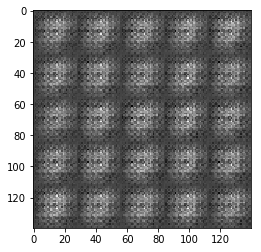

Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.0612
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 2.2097
Epoch 1/2... Discriminator Loss: 0.4803... Generator Loss: 2.5543
Epoch 1/2... Discriminator Loss: 0.4782... Generator Loss: 2.4024
Epoch 1/2... Discriminator Loss: 0.4193... Generator Loss: 3.3933
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 3.6036
Epoch 1/2... Discriminator Loss: 0.4077... Generator Loss: 3.3990
Epoch 1/2... Discriminator Loss: 0.4367... Generator Loss: 2.6538
Epoch 1/2... Discriminator Loss: 0.5143... Generator Loss: 2.0534
Epoch 1/2... Discriminator Loss: 0.4542... Generator Loss: 2.4638
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


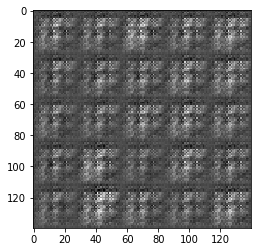

Epoch 1/2... Discriminator Loss: 0.4973... Generator Loss: 2.2909
Epoch 1/2... Discriminator Loss: 0.4221... Generator Loss: 3.2661
Epoch 1/2... Discriminator Loss: 0.6461... Generator Loss: 1.4708
Epoch 1/2... Discriminator Loss: 0.4241... Generator Loss: 3.0594
Epoch 1/2... Discriminator Loss: 0.4772... Generator Loss: 2.4635
Epoch 1/2... Discriminator Loss: 0.4037... Generator Loss: 3.6996
Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 3.2458
Epoch 1/2... Discriminator Loss: 0.4447... Generator Loss: 2.8441
Epoch 1/2... Discriminator Loss: 0.4398... Generator Loss: 3.2599
Epoch 1/2... Discriminator Loss: 0.4132... Generator Loss: 3.4788
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


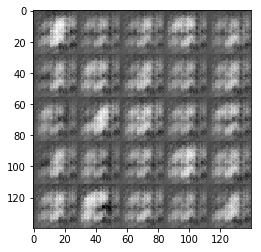

Epoch 1/2... Discriminator Loss: 0.3942... Generator Loss: 3.8333
Epoch 1/2... Discriminator Loss: 0.4560... Generator Loss: 2.8402
Epoch 1/2... Discriminator Loss: 0.4984... Generator Loss: 4.2075
Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 2.5444
Epoch 1/2... Discriminator Loss: 0.4024... Generator Loss: 3.3154
Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 1.4343
Epoch 1/2... Discriminator Loss: 0.4292... Generator Loss: 3.0398
Epoch 1/2... Discriminator Loss: 0.4470... Generator Loss: 2.6835
Epoch 1/2... Discriminator Loss: 0.6220... Generator Loss: 1.7262
Epoch 1/2... Discriminator Loss: 0.4011... Generator Loss: 3.1701
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


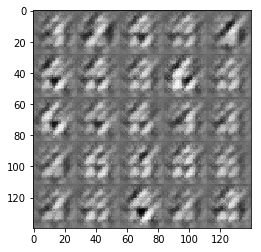

Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 2.2596
Epoch 1/2... Discriminator Loss: 0.4472... Generator Loss: 3.3179
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 2.3411
Epoch 1/2... Discriminator Loss: 0.7184... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 0.5923... Generator Loss: 2.4040
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 4.0535
Epoch 1/2... Discriminator Loss: 0.9970... Generator Loss: 5.6942
Epoch 1/2... Discriminator Loss: 0.5989... Generator Loss: 1.8638
Epoch 1/2... Discriminator Loss: 0.5311... Generator Loss: 2.3834
Epoch 1/2... Discriminator Loss: 0.4796... Generator Loss: 2.4909
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


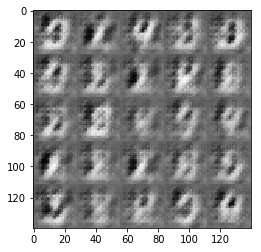

Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 1.9459
Epoch 1/2... Discriminator Loss: 0.4731... Generator Loss: 3.3519
Epoch 1/2... Discriminator Loss: 0.7424... Generator Loss: 1.3887
Epoch 1/2... Discriminator Loss: 0.5616... Generator Loss: 2.0735
Epoch 1/2... Discriminator Loss: 0.7429... Generator Loss: 1.4196
Epoch 1/2... Discriminator Loss: 0.6638... Generator Loss: 1.7384
Epoch 1/2... Discriminator Loss: 0.6234... Generator Loss: 1.6361
Epoch 1/2... Discriminator Loss: 0.5304... Generator Loss: 2.2468
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.9466
Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 1.7875
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


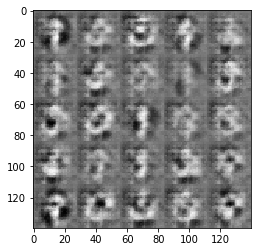

Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 3.0457
Epoch 1/2... Discriminator Loss: 0.7175... Generator Loss: 1.7026
Epoch 1/2... Discriminator Loss: 0.7801... Generator Loss: 2.4923
Epoch 1/2... Discriminator Loss: 0.6148... Generator Loss: 2.6055
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 0.6498... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 2.2963
Epoch 1/2... Discriminator Loss: 0.6609... Generator Loss: 2.5345
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.7838
Epoch 1/2... Discriminator Loss: 0.7670... Generator Loss: 1.6952
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


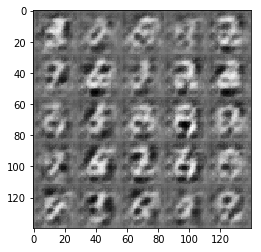

Epoch 1/2... Discriminator Loss: 1.0347... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 0.7191... Generator Loss: 1.7285
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 0.6814... Generator Loss: 2.1580
Epoch 1/2... Discriminator Loss: 0.7293... Generator Loss: 1.7230
Epoch 1/2... Discriminator Loss: 0.6762... Generator Loss: 2.2977
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.7609
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 1.3390
Epoch 1/2... Discriminator Loss: 0.8272... Generator Loss: 1.3210
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


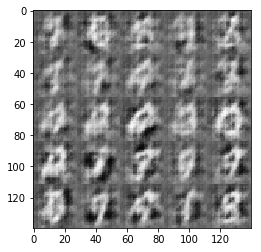

Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.8211
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 0.9026... Generator Loss: 1.5478
Epoch 1/2... Discriminator Loss: 0.6976... Generator Loss: 1.6438
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 1.9437
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.3506
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 1.4658... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 0.8124... Generator Loss: 1.5767
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.5031
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


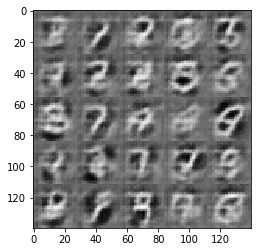

Epoch 1/2... Discriminator Loss: 0.6847... Generator Loss: 1.9935
Epoch 1/2... Discriminator Loss: 0.6266... Generator Loss: 2.0590
Epoch 1/2... Discriminator Loss: 0.9130... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 1.4230
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.7205
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 1.7792
Epoch 1/2... Discriminator Loss: 0.8916... Generator Loss: 1.5966
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 1.5332
Epoch 1/2... Discriminator Loss: 0.8482... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 1.2207
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


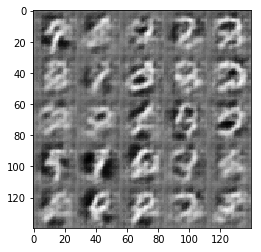

Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 0.8311... Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 0.8283... Generator Loss: 1.1913
Epoch 1/2... Discriminator Loss: 0.8671... Generator Loss: 1.6541
Epoch 1/2... Discriminator Loss: 0.7708... Generator Loss: 1.3892
Epoch 1/2... Discriminator Loss: 0.8293... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 0.6821... Generator Loss: 1.6327
Epoch 1/2... Discriminator Loss: 0.9278... Generator Loss: 1.2100
Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.8625
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 1.0091
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


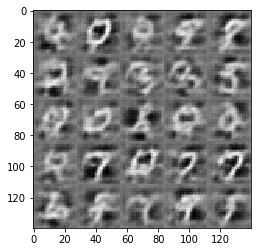

Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 2.2565
Epoch 1/2... Discriminator Loss: 0.7564... Generator Loss: 1.3740
Epoch 1/2... Discriminator Loss: 0.8868... Generator Loss: 1.4791
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 2.0942
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.3674
Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 1.6449
Epoch 1/2... Discriminator Loss: 0.8148... Generator Loss: 2.1489
Epoch 1/2... Discriminator Loss: 0.7425... Generator Loss: 1.4978
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


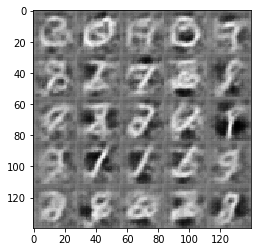

Epoch 1/2... Discriminator Loss: 0.8504... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 0.8595... Generator Loss: 1.2713
Epoch 1/2... Discriminator Loss: 0.9317... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 1.5557
Epoch 1/2... Discriminator Loss: 0.6930... Generator Loss: 2.1452
Epoch 1/2... Discriminator Loss: 0.7413... Generator Loss: 1.4549
Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.2505
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.3866
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 0.9204... Generator Loss: 1.0449
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


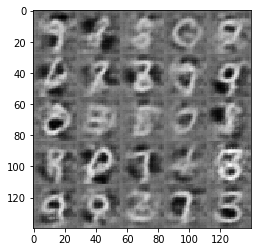

Epoch 1/2... Discriminator Loss: 0.8903... Generator Loss: 1.6707
Epoch 1/2... Discriminator Loss: 0.9676... Generator Loss: 1.1834
Epoch 1/2... Discriminator Loss: 0.8341... Generator Loss: 1.4507
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 1.8148
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.0020
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.1991
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 0.7498... Generator Loss: 1.7490
Epoch 1/2... Discriminator Loss: 0.6784... Generator Loss: 1.8113
Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 1.2414
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


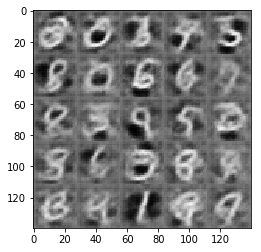

Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 1.8091
Epoch 1/2... Discriminator Loss: 0.9297... Generator Loss: 1.2045
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.4273
Epoch 1/2... Discriminator Loss: 0.9340... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 1.0107... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 0.9515... Generator Loss: 1.3471
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.6488
Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 1.4091
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 0.9182
Epoch 1/2... Discriminator Loss: 0.7840... Generator Loss: 1.7102
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


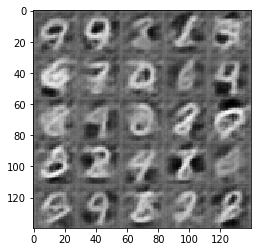

Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 0.7203... Generator Loss: 1.9094
Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 1.5595
Epoch 1/2... Discriminator Loss: 0.8317... Generator Loss: 2.0932
Epoch 1/2... Discriminator Loss: 0.8659... Generator Loss: 1.1021
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 1.0436
Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 1.6647
Epoch 1/2... Discriminator Loss: 0.8656... Generator Loss: 1.2603
Epoch 1/2... Discriminator Loss: 0.7621... Generator Loss: 1.4021
Epoch 1/2... Discriminator Loss: 0.9778... Generator Loss: 0.9018
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


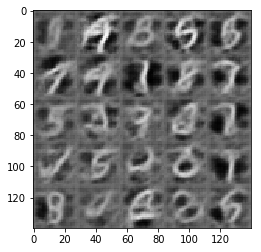

Epoch 1/2... Discriminator Loss: 0.8628... Generator Loss: 1.2497
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 1.2764
Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 1.4825
Epoch 1/2... Discriminator Loss: 0.8932... Generator Loss: 0.9878
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.8025
Epoch 1/2... Discriminator Loss: 0.8390... Generator Loss: 1.7535
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 0.7607... Generator Loss: 1.5732
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.3242
Epoch 1/2... Discriminator Loss: 0.7263... Generator Loss: 1.8019
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


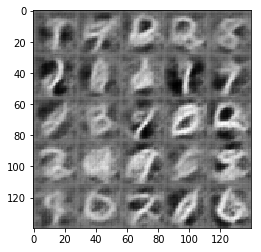

Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 1.6232
Epoch 1/2... Discriminator Loss: 0.6761... Generator Loss: 2.1920
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 0.9852... Generator Loss: 1.3096
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 1.4696
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 1.0677
Epoch 1/2... Discriminator Loss: 0.7751... Generator Loss: 1.6691
Epoch 1/2... Discriminator Loss: 0.7398... Generator Loss: 1.4916
Epoch 1/2... Discriminator Loss: 0.7135... Generator Loss: 1.5481
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


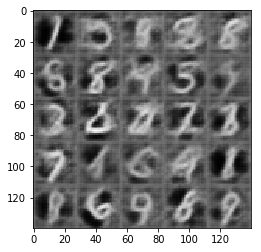

Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 0.9070... Generator Loss: 1.2654
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 1.6147
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.2854
Epoch 1/2... Discriminator Loss: 0.8326... Generator Loss: 1.2854
train->len(losses):  188
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False
Epoch 2/2... Discriminator Loss: 0.8240... Generator Loss: 1.4172
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.2834
Epoch 2/2... Discriminator Loss: 0.9345... Generator Loss: 1.0005
Epoch 2/2... Discriminator Loss: 0.7765... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 0.7423... Generator Loss: 1.3582
Epoch 2/2... Discriminat

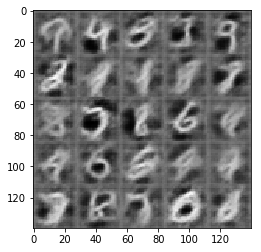

Epoch 2/2... Discriminator Loss: 0.8202... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 0.9562... Generator Loss: 1.0255
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.1294
Epoch 2/2... Discriminator Loss: 0.7774... Generator Loss: 1.3751
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.9399
Epoch 2/2... Discriminator Loss: 0.7022... Generator Loss: 1.6393
Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.5665
Epoch 2/2... Discriminator Loss: 0.8508... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.4816
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.2771
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


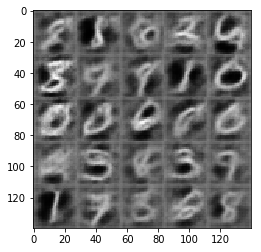

Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 0.7706... Generator Loss: 1.3470
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.7287
Epoch 2/2... Discriminator Loss: 0.7995... Generator Loss: 1.1983
Epoch 2/2... Discriminator Loss: 0.9233... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.3747
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.7002
Epoch 2/2... Discriminator Loss: 0.9039... Generator Loss: 1.0616
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 1.6192
Epoch 2/2... Discriminator Loss: 1.2664... Generator Loss: 0.6323
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


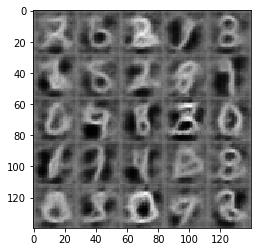

Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.5368
Epoch 2/2... Discriminator Loss: 0.9891... Generator Loss: 0.9207
Epoch 2/2... Discriminator Loss: 0.8617... Generator Loss: 1.0917
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 0.6583
Epoch 2/2... Discriminator Loss: 1.1409... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.7497
Epoch 2/2... Discriminator Loss: 1.0471... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.1168
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.2948
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


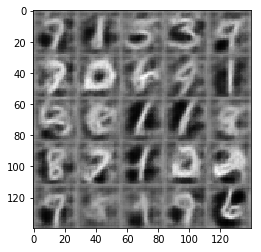

Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 0.6718
Epoch 2/2... Discriminator Loss: 0.6390... Generator Loss: 1.4638
Epoch 2/2... Discriminator Loss: 0.7813... Generator Loss: 2.1200
Epoch 2/2... Discriminator Loss: 1.2557... Generator Loss: 0.6402
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 0.9424... Generator Loss: 1.0604
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.0678
Epoch 2/2... Discriminator Loss: 0.9930... Generator Loss: 1.2727
Epoch 2/2... Discriminator Loss: 1.1432... Generator Loss: 0.7172
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


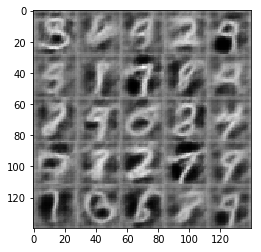

Epoch 2/2... Discriminator Loss: 1.0210... Generator Loss: 1.1779
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.2050
Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.8516... Generator Loss: 1.1363
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 1.2118
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 1.0090
Epoch 2/2... Discriminator Loss: 0.8804... Generator Loss: 1.5469
Epoch 2/2... Discriminator Loss: 0.6466... Generator Loss: 1.7510
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.1468
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


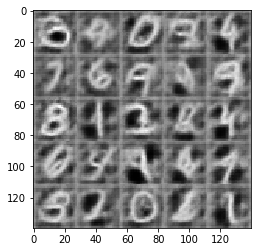

Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.1505
Epoch 2/2... Discriminator Loss: 1.7644... Generator Loss: 0.3395
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 0.8961... Generator Loss: 1.3799
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.7258
Epoch 2/2... Discriminator Loss: 0.9890... Generator Loss: 1.1791
Epoch 2/2... Discriminator Loss: 0.9478... Generator Loss: 1.1460
Epoch 2/2... Discriminator Loss: 0.8486... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 0.8651... Generator Loss: 1.5087
Epoch 2/2... Discriminator Loss: 0.9063... Generator Loss: 1.0903
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


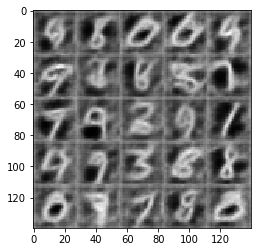

Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 0.9806
Epoch 2/2... Discriminator Loss: 1.5489... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 1.1660
Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 2.1326
Epoch 2/2... Discriminator Loss: 0.8281... Generator Loss: 1.7215
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 1.4153
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.7876
Epoch 2/2... Discriminator Loss: 0.7398... Generator Loss: 1.4314
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.1398... Generator Loss: 0.7380
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


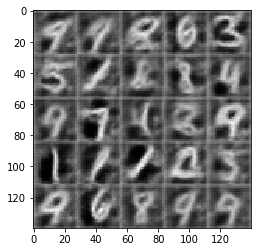

Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.0663
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.7057
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.3545
Epoch 2/2... Discriminator Loss: 0.7789... Generator Loss: 1.5598
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.9246
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 0.6780
Epoch 2/2... Discriminator Loss: 1.8610... Generator Loss: 0.2996
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 1.2131
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


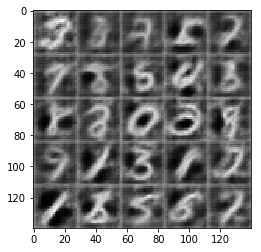

Epoch 2/2... Discriminator Loss: 0.7518... Generator Loss: 1.4140
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.1186
Epoch 2/2... Discriminator Loss: 0.9129... Generator Loss: 1.4180
Epoch 2/2... Discriminator Loss: 1.0115... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.0904
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.7544
Epoch 2/2... Discriminator Loss: 1.0160... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.6646
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.1038... Generator Loss: 0.7604
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


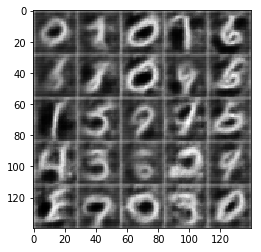

Epoch 2/2... Discriminator Loss: 1.1786... Generator Loss: 0.7100
Epoch 2/2... Discriminator Loss: 0.8938... Generator Loss: 1.0905
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.3249
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 0.8857
Epoch 2/2... Discriminator Loss: 0.9272... Generator Loss: 1.4494
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 0.8737
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 0.9403
Epoch 2/2... Discriminator Loss: 0.8413... Generator Loss: 1.4699
Epoch 2/2... Discriminator Loss: 1.0861... Generator Loss: 1.0167
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


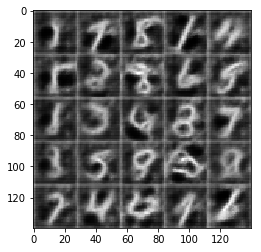

Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 0.6530
Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 1.5522
Epoch 2/2... Discriminator Loss: 0.8449... Generator Loss: 1.1330
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.9202
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 0.8743
Epoch 2/2... Discriminator Loss: 0.8809... Generator Loss: 1.0772
Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.8580
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.5626
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 1.7059
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 1.0511
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


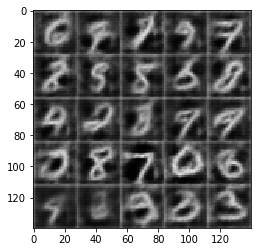

Epoch 2/2... Discriminator Loss: 0.8501... Generator Loss: 1.1509
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.9229
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 0.9357
Epoch 2/2... Discriminator Loss: 0.6514... Generator Loss: 1.9129
Epoch 2/2... Discriminator Loss: 1.0831... Generator Loss: 0.8415
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.3099
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 0.9573
Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 1.5676
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 0.8792
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.5949
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


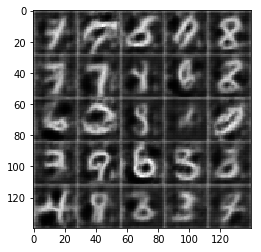

Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.9883
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.7857
Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 2.2472
Epoch 2/2... Discriminator Loss: 0.9198... Generator Loss: 1.1506
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.7194
Epoch 2/2... Discriminator Loss: 0.8412... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 0.8000... Generator Loss: 1.2952
Epoch 2/2... Discriminator Loss: 0.6977... Generator Loss: 1.5616
Epoch 2/2... Discriminator Loss: 1.5477... Generator Loss: 0.4362
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


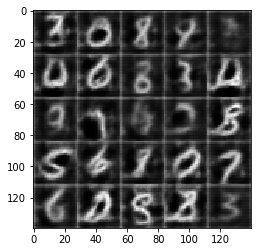

Epoch 2/2... Discriminator Loss: 0.7072... Generator Loss: 1.4073
Epoch 2/2... Discriminator Loss: 1.0300... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 1.6829... Generator Loss: 2.8995
Epoch 2/2... Discriminator Loss: 1.0803... Generator Loss: 0.7979
Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.4567
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 1.0601
Epoch 2/2... Discriminator Loss: 1.0630... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.8284... Generator Loss: 1.0826
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 0.9908
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.2332
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


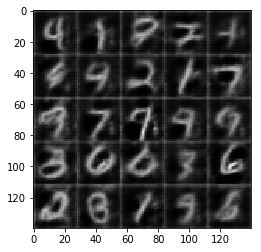

Epoch 2/2... Discriminator Loss: 0.9583... Generator Loss: 1.0317
Epoch 2/2... Discriminator Loss: 0.9545... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 0.7482... Generator Loss: 1.3677
Epoch 2/2... Discriminator Loss: 0.6868... Generator Loss: 1.4654
Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.0907
Epoch 2/2... Discriminator Loss: 1.0101... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 1.0900
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 0.8272
Epoch 2/2... Discriminator Loss: 1.1828... Generator Loss: 0.6980
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


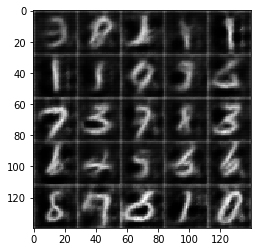

Epoch 2/2... Discriminator Loss: 0.9755... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.3274
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.5185
Epoch 2/2... Discriminator Loss: 0.7859... Generator Loss: 1.7480
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 2.2176
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.4829
Epoch 2/2... Discriminator Loss: 1.5507... Generator Loss: 0.4484
Epoch 2/2... Discriminator Loss: 0.6904... Generator Loss: 1.7271
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.3257
Epoch 2/2... Discriminator Loss: 0.7451... Generator Loss: 1.4660
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


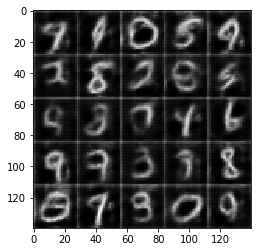

Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.6582
Epoch 2/2... Discriminator Loss: 1.4675... Generator Loss: 0.6465
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 1.1693
Epoch 2/2... Discriminator Loss: 0.8237... Generator Loss: 1.3756
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 1.0473
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.2894
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.3379
Epoch 2/2... Discriminator Loss: 0.6691... Generator Loss: 1.5723
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


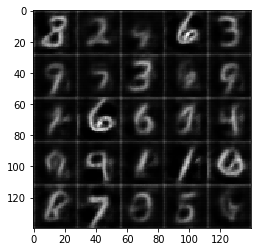

Epoch 2/2... Discriminator Loss: 0.7778... Generator Loss: 1.3074
Epoch 2/2... Discriminator Loss: 0.8816... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 0.9437... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 0.9674... Generator Loss: 0.9482
Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 1.2662
Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 1.1789
Epoch 2/2... Discriminator Loss: 0.8113... Generator Loss: 1.1789
train->len(losses):  376
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  1
generator->is_train:  False


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  True
model_opt->g_vars: 
Tensor("generator/dense/kernel/read:0", shape=(100, 2048), dtype=float32)
Tensor("generator/dense/bias/read:0", shape=(2048,), dtype=float32)
Tensor("generator/batch_normalization/beta/read:0", shape=(512,), dtype=float32)
Tensor("generator/batch_normalization/gamma/read:0", shape=(512,), dtype=float32)
Tensor("generator/conv2d_transpose/kernel/read:0", shape=(5, 5, 256, 512), dtype=float32)
Tensor("generator/conv2d_transpose/bias/read:0", shape=(256,), dtype=float32)
Tensor("generator/batch_normalization_1/beta/read:0", shape=(256,), dtype=float32)
Tensor("generator/batch_normalization_1/gamma/read:0", shape=(256,), dtype=float32)
Tensor("generator/conv2d_transpose_1/kernel/read:0", shape=(5, 5, 128, 256), dtype=float32)
Tensor("generator/conv2d_transpose_1/bias/read:0", shape=(128,), dtype=float32)
Tensor("generator/batch_normalization_2/beta/read:0", shape=(128,), dtype=fl

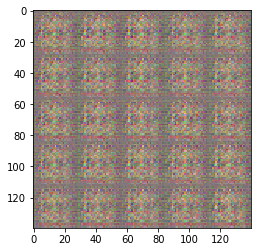

Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.8515
Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 2.2035
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.2601
Epoch 1/1... Discriminator Loss: 0.4329... Generator Loss: 2.8018
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 2.2307
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 2.7180
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 2.6720
Epoch 1/1... Discriminator Loss: 0.4427... Generator Loss: 2.6551
Epoch 1/1... Discriminator Loss: 0.4434... Generator Loss: 2.8108
Epoch 1/1... Discriminator Loss: 0.3999... Generator Loss: 3.2317
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


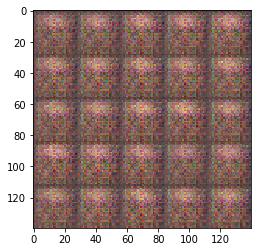

Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 2.7432
Epoch 1/1... Discriminator Loss: 0.4216... Generator Loss: 2.7957
Epoch 1/1... Discriminator Loss: 0.4047... Generator Loss: 3.1179
Epoch 1/1... Discriminator Loss: 0.3902... Generator Loss: 3.1690
Epoch 1/1... Discriminator Loss: 0.4220... Generator Loss: 3.1299
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.1858
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.4292
Epoch 1/1... Discriminator Loss: 0.3766... Generator Loss: 3.4956
Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.0727
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 2.8915
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


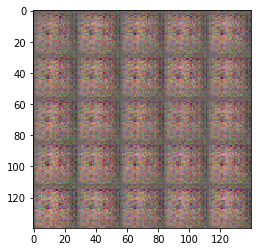

Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 3.6076
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 3.1484
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 4.8806
Epoch 1/1... Discriminator Loss: 0.3844... Generator Loss: 3.4344
Epoch 1/1... Discriminator Loss: 0.4221... Generator Loss: 2.9308
Epoch 1/1... Discriminator Loss: 0.3655... Generator Loss: 3.6857
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.6612
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 3.4296
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.6502
Epoch 1/1... Discriminator Loss: 0.4210... Generator Loss: 2.9962
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


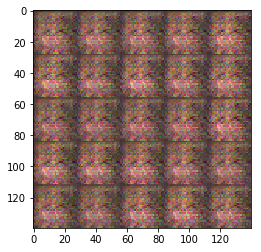

Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 2.6881
Epoch 1/1... Discriminator Loss: 0.3759... Generator Loss: 3.9621
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 2.0559
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 3.1766
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 3.1949
Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 4.5586
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.0865
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 2.9026
Epoch 1/1... Discriminator Loss: 0.4947... Generator Loss: 2.3878
Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 2.8974
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


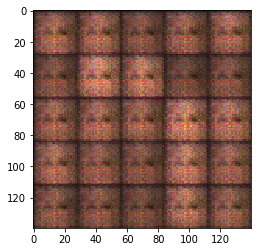

Epoch 1/1... Discriminator Loss: 0.5100... Generator Loss: 2.5037
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 2.2591
Epoch 1/1... Discriminator Loss: 0.5465... Generator Loss: 2.0006
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.2180
Epoch 1/1... Discriminator Loss: 0.4982... Generator Loss: 2.3364
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 1.9506
Epoch 1/1... Discriminator Loss: 0.5743... Generator Loss: 2.3170
Epoch 1/1... Discriminator Loss: 0.5760... Generator Loss: 1.9328
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.4475
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.9232
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


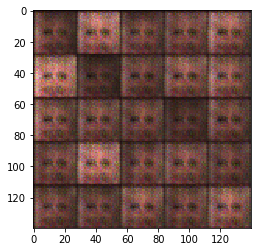

Epoch 1/1... Discriminator Loss: 0.5023... Generator Loss: 2.5280
Epoch 1/1... Discriminator Loss: 0.4628... Generator Loss: 2.6104
Epoch 1/1... Discriminator Loss: 0.7062... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.5367... Generator Loss: 2.3150
Epoch 1/1... Discriminator Loss: 0.5389... Generator Loss: 2.3147
Epoch 1/1... Discriminator Loss: 0.6641... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 2.2567
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 0.5386... Generator Loss: 2.2738
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 2.7875
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


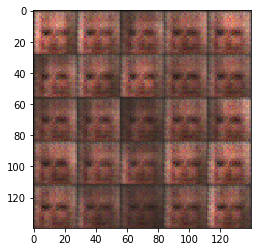

Epoch 1/1... Discriminator Loss: 0.5155... Generator Loss: 2.2851
Epoch 1/1... Discriminator Loss: 0.4429... Generator Loss: 2.9999
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 2.8688
Epoch 1/1... Discriminator Loss: 0.5524... Generator Loss: 2.3646
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.4387
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 1.8586
Epoch 1/1... Discriminator Loss: 0.6400... Generator Loss: 2.2185
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 1.8662
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.4906
Epoch 1/1... Discriminator Loss: 0.6599... Generator Loss: 2.7392
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


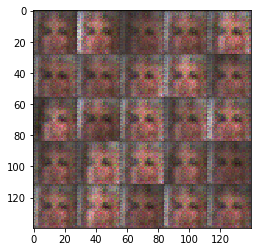

Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 2.7807
Epoch 1/1... Discriminator Loss: 0.5427... Generator Loss: 2.3575
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 2.0693
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.2470
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.7181
Epoch 1/1... Discriminator Loss: 0.5364... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.3682
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 2.4494
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 2.3304
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 2.4315
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


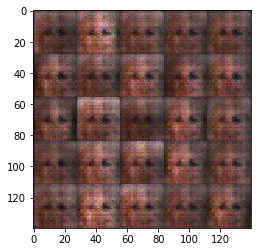

Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 2.4206
Epoch 1/1... Discriminator Loss: 0.6617... Generator Loss: 1.7630
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.9554
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 2.1821
Epoch 1/1... Discriminator Loss: 0.6833... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.4004
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 2.5006
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 2.0921
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.7618
Epoch 1/1... Discriminator Loss: 0.6754... Generator Loss: 2.4825
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


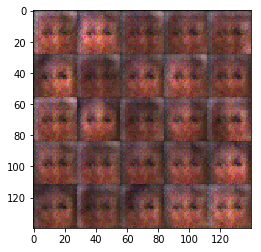

Epoch 1/1... Discriminator Loss: 0.7834... Generator Loss: 1.4162
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.9062
Epoch 1/1... Discriminator Loss: 0.4935... Generator Loss: 2.4513
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.7298
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.4852
Epoch 1/1... Discriminator Loss: 0.5877... Generator Loss: 2.3134
Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 2.4302
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 2.1087
Epoch 1/1... Discriminator Loss: 0.4516... Generator Loss: 2.5686
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


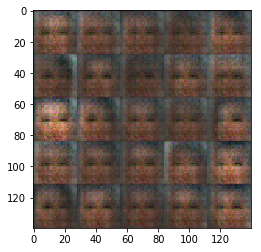

Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 2.2633
Epoch 1/1... Discriminator Loss: 0.3894... Generator Loss: 3.2944
Epoch 1/1... Discriminator Loss: 0.5020... Generator Loss: 2.6710
Epoch 1/1... Discriminator Loss: 0.6032... Generator Loss: 1.7225
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 1.9996
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 2.1107
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 0.6274... Generator Loss: 1.9610
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 2.1488
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


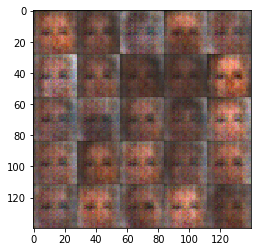

Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 2.0341
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.8658
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 2.2228
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.5610
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 2.6205
Epoch 1/1... Discriminator Loss: 0.5676... Generator Loss: 2.1108
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.6614
Epoch 1/1... Discriminator Loss: 0.6156... Generator Loss: 2.1900
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 2.0991
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


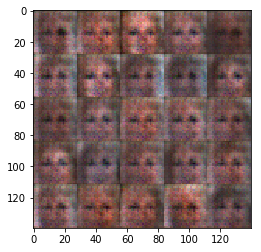

Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 2.1322
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 2.7172
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 2.2293
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 2.1232
Epoch 1/1... Discriminator Loss: 0.6226... Generator Loss: 2.3245
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 1.9903
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 1.8558
Epoch 1/1... Discriminator Loss: 0.6845... Generator Loss: 1.5128
Epoch 1/1... Discriminator Loss: 0.7323... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.6363
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


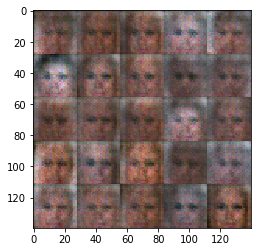

Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.9492
Epoch 1/1... Discriminator Loss: 0.7384... Generator Loss: 2.1478
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 0.6303... Generator Loss: 2.0234
Epoch 1/1... Discriminator Loss: 0.6087... Generator Loss: 1.9609
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.9067
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.9485
Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 2.1858
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.7683
Epoch 1/1... Discriminator Loss: 0.5754... Generator Loss: 1.9785
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


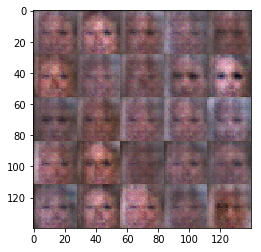

Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.6626
Epoch 1/1... Discriminator Loss: 0.8178... Generator Loss: 1.2231
Epoch 1/1... Discriminator Loss: 0.7711... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.4739
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.8303
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.2124
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 2.3593
Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 2.2159
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.8197
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.3465
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


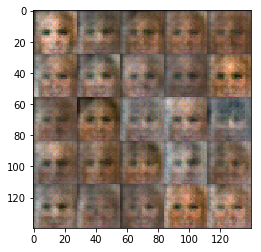

Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 2.2691
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 2.5388
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 2.0561
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 2.7042
Epoch 1/1... Discriminator Loss: 0.6130... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.5233
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 1.6456
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 2.0395
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


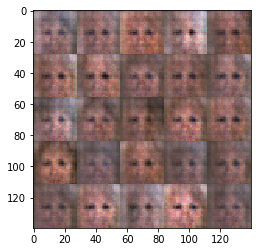

Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.8833
Epoch 1/1... Discriminator Loss: 0.6431... Generator Loss: 2.0486
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 0.6771... Generator Loss: 2.2053
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.9562... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.3211
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.3145
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 2.1738
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


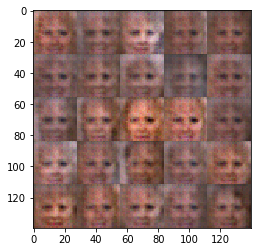

Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 2.1551
Epoch 1/1... Discriminator Loss: 0.6570... Generator Loss: 1.8678
Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3868
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.4042
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 2.5155
Epoch 1/1... Discriminator Loss: 0.8257... Generator Loss: 2.1219
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 2.2438
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 2.2894
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.7281
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


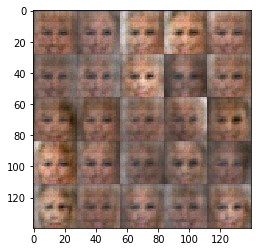

Epoch 1/1... Discriminator Loss: 0.7877... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 2.0703
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 2.3638
Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.6851
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.8933
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.8355
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.6430
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.5574
Epoch 1/1... Discriminator Loss: 0.6265... Generator Loss: 1.9820
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


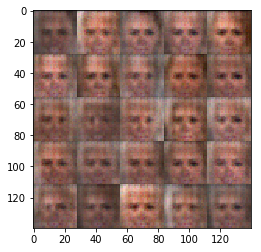

Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.3554
Epoch 1/1... Discriminator Loss: 0.7488... Generator Loss: 1.9603
Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 1.6459
Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.0754
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 1.7456
Epoch 1/1... Discriminator Loss: 0.8596... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 0.6509... Generator Loss: 1.9781
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.4316
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


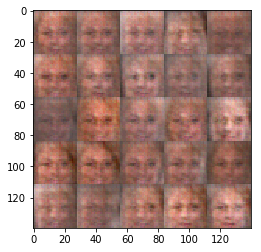

Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 2.0560
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.7610
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 2.1639
Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 2.3070
Epoch 1/1... Discriminator Loss: 0.6524... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 0.9666... Generator Loss: 1.7439
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 0.7346... Generator Loss: 1.9240
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.8702... Generator Loss: 1.9113
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


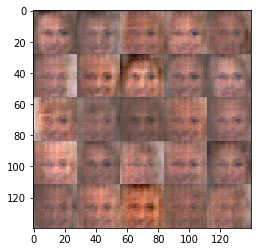

Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 1.5688
Epoch 1/1... Discriminator Loss: 0.6551... Generator Loss: 2.0243
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.5760
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.7780
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.6791
Epoch 1/1... Discriminator Loss: 0.9886... Generator Loss: 1.2641
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.5006
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 2.0108
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


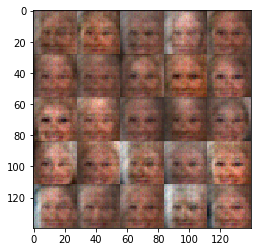

Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.5685
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.6730
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.6395
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.3725
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.6652
Epoch 1/1... Discriminator Loss: 0.7591... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.5162
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


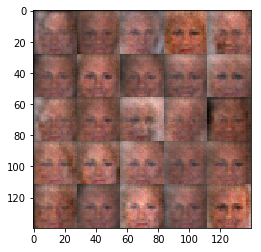

Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 0.7328... Generator Loss: 1.7117
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.5983
Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.9305
Epoch 1/1... Discriminator Loss: 0.6831... Generator Loss: 1.7401
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.4722
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.5080
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 2.0587
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


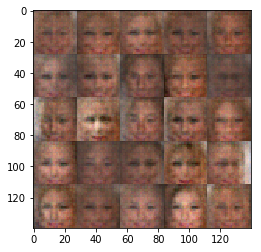

Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 1.8162
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 2.1421
Epoch 1/1... Discriminator Loss: 0.7444... Generator Loss: 1.6221
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.3585
Epoch 1/1... Discriminator Loss: 0.7826... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.8939
Epoch 1/1... Discriminator Loss: 0.7586... Generator Loss: 1.5996
Epoch 1/1... Discriminator Loss: 0.7842... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.7126
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


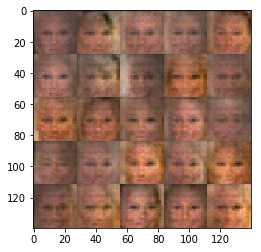

Epoch 1/1... Discriminator Loss: 0.6867... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 0.7532... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 1.9471
Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 2.0001
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.7307
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 0.7609... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.7967
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


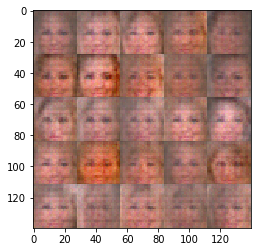

Epoch 1/1... Discriminator Loss: 0.7672... Generator Loss: 1.6761
Epoch 1/1... Discriminator Loss: 0.7538... Generator Loss: 2.0210
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 1.8652
Epoch 1/1... Discriminator Loss: 0.8704... Generator Loss: 1.4743
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.6924
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.6462
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.6085
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


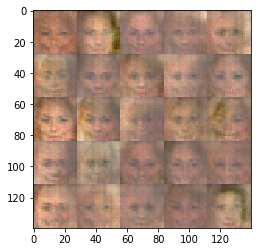

Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 2.1150
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.1988
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.6410
Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.4972
Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 2.1360
Epoch 1/1... Discriminator Loss: 0.8328... Generator Loss: 1.5231
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


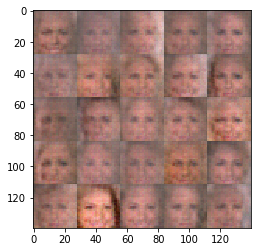

Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.5285
Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 0.9949
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 1.8411
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.7455
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 1.6467
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.7675
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.9104
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 2.1602
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.4805
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


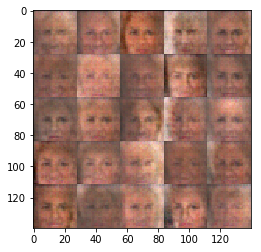

Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.6934
Epoch 1/1... Discriminator Loss: 0.7589... Generator Loss: 1.8731
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.9569
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 2.0049
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.3224
Epoch 1/1... Discriminator Loss: 0.6667... Generator Loss: 1.9098
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.7088
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.3077
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


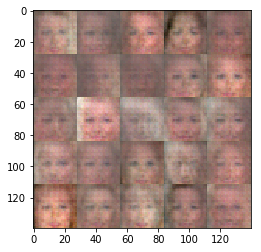

Epoch 1/1... Discriminator Loss: 0.9472... Generator Loss: 1.4609
Epoch 1/1... Discriminator Loss: 0.9439... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 0.8151... Generator Loss: 1.4351
Epoch 1/1... Discriminator Loss: 0.6899... Generator Loss: 1.9163
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.3401
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.5917
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.1623
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


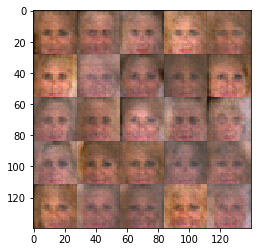

Epoch 1/1... Discriminator Loss: 0.8253... Generator Loss: 1.8723
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.5140
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.7036
Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.6992
Epoch 1/1... Discriminator Loss: 0.7449... Generator Loss: 1.4198
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.5246
Epoch 1/1... Discriminator Loss: 0.8595... Generator Loss: 1.5804
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.4220
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


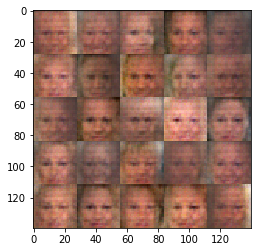

Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.3724
Epoch 1/1... Discriminator Loss: 0.7473... Generator Loss: 1.7834
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.5126
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 1.5444
Epoch 1/1... Discriminator Loss: 0.9578... Generator Loss: 1.2137
Epoch 1/1... Discriminator Loss: 0.6861... Generator Loss: 1.8747
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 0.7236... Generator Loss: 1.7784
Epoch 1/1... Discriminator Loss: 0.7959... Generator Loss: 1.3876
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


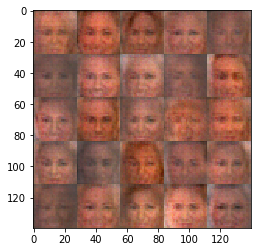

Epoch 1/1... Discriminator Loss: 0.7801... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 0.8261... Generator Loss: 1.6076
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.4458
Epoch 1/1... Discriminator Loss: 0.9118... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 0.9085... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.3665
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.6272
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.4954
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.2951
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


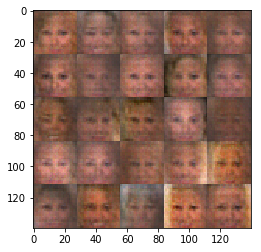

Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.8911... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 0.8072... Generator Loss: 1.6247
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.5388
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.5828
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.8840
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.7107
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


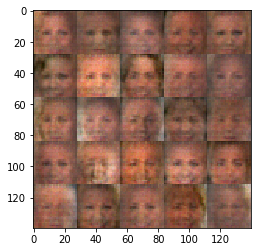

Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.4125
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.9683
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.3956
Epoch 1/1... Discriminator Loss: 0.6718... Generator Loss: 1.7658
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 2.1536
Epoch 1/1... Discriminator Loss: 0.8578... Generator Loss: 1.4640
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.9796
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.7238
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 1.5231
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


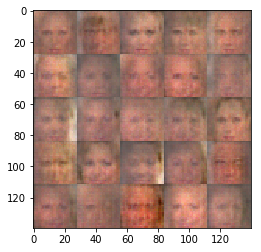

Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 1.0343
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.8039
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.6636
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.4310
Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.5708
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.5056
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.4331
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 1.7503
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


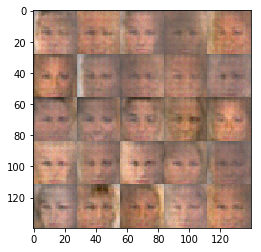

Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3209
Epoch 1/1... Discriminator Loss: 0.7088... Generator Loss: 1.6254
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 0.9068... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 0.7305... Generator Loss: 1.5828
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.5370
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.5323
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.2363
Epoch 1/1... Discriminator Loss: 0.7112... Generator Loss: 1.7777
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.6449
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


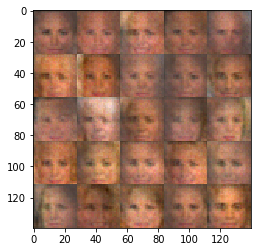

Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.3362
Epoch 1/1... Discriminator Loss: 0.6973... Generator Loss: 1.4512
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.7044
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 0.9239... Generator Loss: 1.3270
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.4995
Epoch 1/1... Discriminator Loss: 0.8931... Generator Loss: 1.2716
Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.3948
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


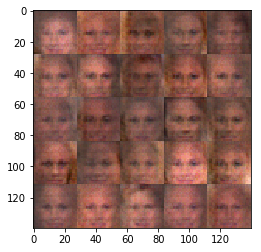

Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.7701... Generator Loss: 1.8934
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.3927
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 1.0058... Generator Loss: 1.1249
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 1.8183
Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.4311
Epoch 1/1... Discriminator Loss: 0.7572... Generator Loss: 1.5894
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


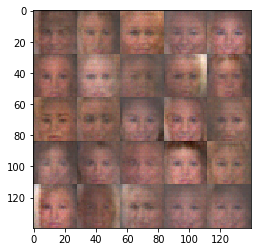

Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.5428
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.6469
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.6239
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 0.6937... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.5443
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.6950
Epoch 1/1... Discriminator Loss: 0.7996... Generator Loss: 1.4766
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.1261
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


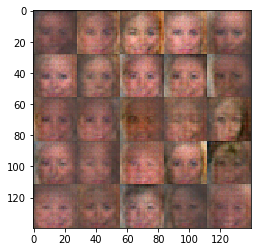

Epoch 1/1... Discriminator Loss: 0.7145... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 1.6764
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.1983
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 0.7548... Generator Loss: 1.6285
Epoch 1/1... Discriminator Loss: 0.8310... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.5878
Epoch 1/1... Discriminator Loss: 0.7690... Generator Loss: 1.8618
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.1088
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.1806
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


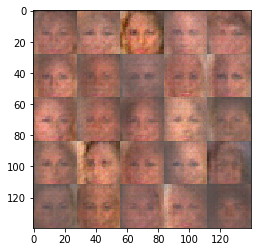

Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.8306
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.2315
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.6349
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.4516
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.3063
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.4563
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.4885
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


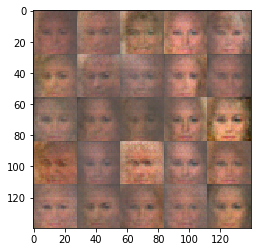

Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.2506
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 0.8449... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.5539
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.4514
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 0.8933... Generator Loss: 1.3848
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


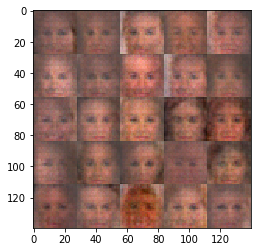

Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 2.6347
Epoch 1/1... Discriminator Loss: 0.9091... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.9066... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.4742
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 1.9978
Epoch 1/1... Discriminator Loss: 0.8576... Generator Loss: 1.8526
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 1.7599
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.2065
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


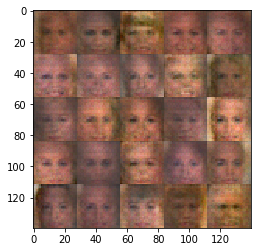

Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 0.7216... Generator Loss: 1.9167
Epoch 1/1... Discriminator Loss: 0.7867... Generator Loss: 1.4413
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.4919
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.1609
Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.6643
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.3515
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.1823
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.7145
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


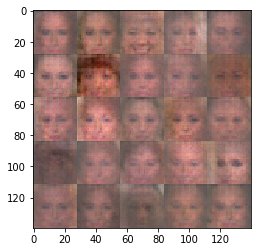

Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 1.3888
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.4927
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.4600
Epoch 1/1... Discriminator Loss: 0.8963... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 0.7864... Generator Loss: 1.7867
Epoch 1/1... Discriminator Loss: 0.8979... Generator Loss: 1.5466
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.6096
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 0.7201... Generator Loss: 1.5076
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


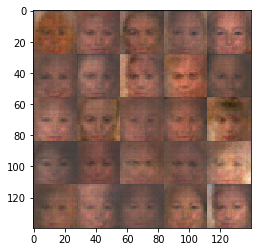

Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.1180
Epoch 1/1... Discriminator Loss: 0.7625... Generator Loss: 1.6031
Epoch 1/1... Discriminator Loss: 0.7246... Generator Loss: 1.5878
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.4348
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.8264
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 0.9047... Generator Loss: 1.4492
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.7183
Epoch 1/1... Discriminator Loss: 0.7388... Generator Loss: 1.7146
Epoch 1/1... Discriminator Loss: 0.8185... Generator Loss: 1.3199
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


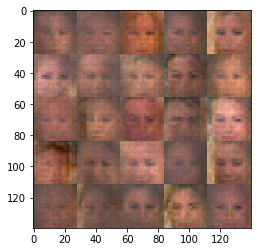

Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.4873
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.5226
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.3646
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


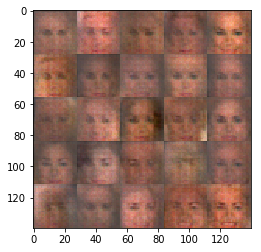

Epoch 1/1... Discriminator Loss: 0.9813... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.3402
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.2398
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.3375
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 2.2109
Epoch 1/1... Discriminator Loss: 0.8810... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.4836
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.3273
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 0.8886
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


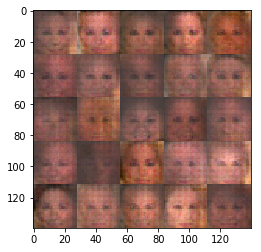

Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.1136
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.4438
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.7237
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 2.0326
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.3430
Epoch 1/1... Discriminator Loss: 0.7595... Generator Loss: 1.3449
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.2848
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


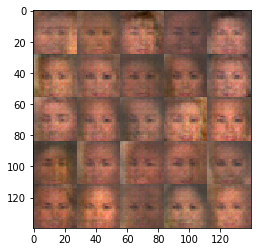

Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.6009
Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.3114
Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.2541
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.5777
Epoch 1/1... Discriminator Loss: 0.7614... Generator Loss: 1.6465
Epoch 1/1... Discriminator Loss: 0.8380... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.8894
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 1.3031
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


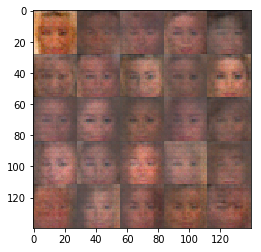

Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 1.2781
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.3691
Epoch 1/1... Discriminator Loss: 0.9410... Generator Loss: 1.2293
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.5363
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.4393
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.5898
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


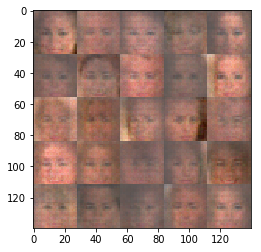

Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.5123
Epoch 1/1... Discriminator Loss: 0.7606... Generator Loss: 1.5944
Epoch 1/1... Discriminator Loss: 0.9792... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.3044
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 1.0293... Generator Loss: 1.3192
Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.5386
Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.2203
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.6145
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


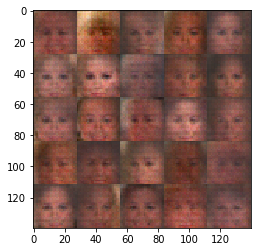

Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 0.9793
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 1.0928... Generator Loss: 1.5106
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.3308
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.9739
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.3737
Epoch 1/1... Discriminator Loss: 0.8197... Generator Loss: 1.3673
Epoch 1/1... Discriminator Loss: 0.8697... Generator Loss: 1.0764
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


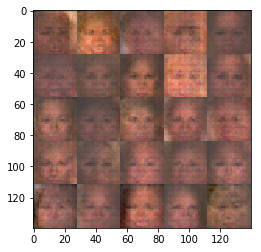

Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 0.8225... Generator Loss: 1.4931
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.6135
Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.4105
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.9253
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


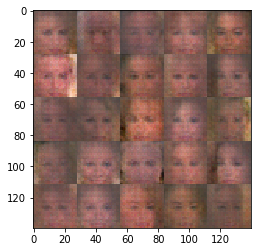

Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.5048
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.6213
Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 0.9371... Generator Loss: 1.1464
Epoch 1/1... Discriminator Loss: 0.7423... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.1566
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


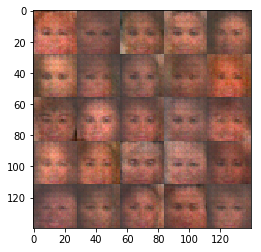

Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.5009
Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.4090
Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.4784
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 1.8040
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 1.0051... Generator Loss: 1.5091
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.3134
Epoch 1/1... Discriminator Loss: 0.7939... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.4776
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


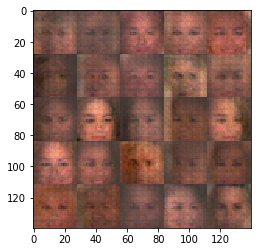

Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 0.7291... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.5569
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.3646
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 0.7458... Generator Loss: 1.6790
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.8618
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


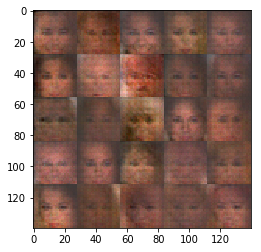

Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 1.6425
Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.4755
Epoch 1/1... Discriminator Loss: 0.8215... Generator Loss: 1.5882
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.3275
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.1691
Epoch 1/1... Discriminator Loss: 1.0187... Generator Loss: 1.1456
Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.5576
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


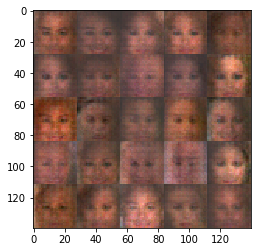

Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 1.1239
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.2271
Epoch 1/1... Discriminator Loss: 0.7894... Generator Loss: 1.4690
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 0.8145... Generator Loss: 1.6870
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9950
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 2.2007
Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.6750
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.2613
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


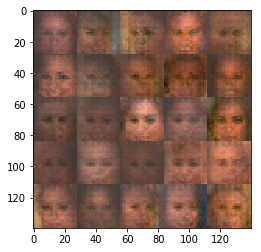

Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 0.9030... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.4589
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.6779
Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.4172
Epoch 1/1... Discriminator Loss: 0.9831... Generator Loss: 1.0550
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


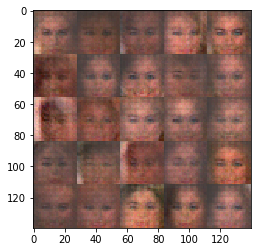

Epoch 1/1... Discriminator Loss: 0.8448... Generator Loss: 1.5711
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 1.2031
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 1.6716
train->len(losses):  634
generator->z.get_shape:  (?, 100)
generator->out_channel_dim:  3
generator->is_train:  False


In [22]:
batch_size = 32
z_dim = 100
#learning_rate = 0.001
learning_rate = 0.0001
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.